# 0.Import section

In [1]:
from sys import exit
import importlib

from astropy.io.votable import is_votable, parse
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
            
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.markers import MarkerStyle

from cosmolopy.distance import comoving_distance_transverse
cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'omega_k_0' : 0.0, 'h' : 0.72}

from stage2 import *

# 1.DATA TREATMENT SECTION

## Checking that file format is correct

In [2]:
pathdata = "outputs/"
data     = ["matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot"]

for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot is a VOtable, right ? True
Size of matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot is 284 



## Getting data

In [3]:
catalog = parse(pathdata+data[0]).get_first_table().array
fields  = np.asarray(catalog.dtype.names)

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([catalog], names=["matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot"])

#Converting to an astropy table for simplicity
table = Table(catalog)      

printSimpleStat(catalog['Separation_ZURICH'], unit=u.arcsec)
print("\nNumber of galaxies in matching catalog:", np.shape(table)[0])

All the galaxies are only listed once in the catalog matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot
Stat for catalog number 0 :
Maximum separation is 0.66913126003908 arcsec.
Mean separation is -3591.127800158525 arcsec.
Median separation is 0.03882939124261448 arcsec.
1st quantile is -9999.0.
3rd quantile is 0.08583675333021239.

Number of galaxies in matching catalog: 284


## 1.1 Correlation between Flux(OII) and SNR

### 1.1.1 Getting OII flux and flux error to compute SNR

In [13]:
redshift = table['Z_MUSE']
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

### 1.1.2 Checking and removing nan values in tables

In [14]:
m = maskToRemoveVal([fluxOII, errflux], astroTableMask=True)
m = np.logical_and(m, maskToRemoveVal([fluxOII, errflux]))

fluxOII, errflux, redshift = applyMask([fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux])

No nan was found in array number 0
No nan was found in array number 1


[False, False]

### 1.1.3 Computing SNR

In [15]:
SNR     = fluxOII/errflux

### 1.1.4 Plotting Flux(OII) vs SNR

File Plots/Selection_plots/Flux_vs_SNR.pdf already exists but overwritting was disabled. Thus exiting without writing.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe129c273c8>,
 <matplotlib.collections.PathCollection at 0x7fe129c2a390>)

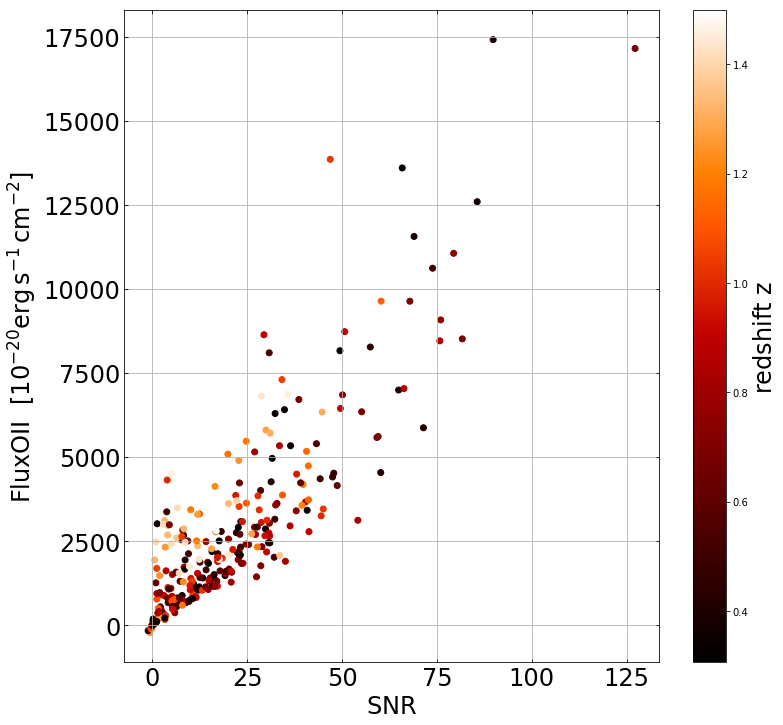

In [16]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

asManyPlots(111, SNR, fluxOII, xlabel=r'$\rm{SNR}$', ylabel=r'$\rm{Flux OII \ \ [10^{-20} erg \, s^{-1} \, cm^{-2}]}$',
            plotFlag=False, color=[redshift], marker='o', cmap='gist_heat', 
            showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/Flux_vs_SNR.pdf', overwrite=False)

## 1.2 Plotting size agains mass

### 1.2.1 Getting data

In [31]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
lmass                 = table['lmass']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size, lmass], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size, lmass]))

lmass, size, fluxOII, errflux, redshift = applyMask([lmass, size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size, lmass])

#Compute SNR
SNR     = fluxOII/errflux

#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
zFromGalsWeWant, sizeGalsWeWant, lmassGalsWeWant = applyMask([redshift, size, lmass], m)

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3


### 1.2.2 Converting size from arcsec to kpc

In [32]:
#Transforming from arcsec to radians
sizeGalsWeWant /= 3600 #arcsec to degrees
sizeGalsWeWant *= np.pi/180.0 #degrees to radians

#Transforming angular size in comsological transverse size
sizeGalsWeWant *= comoving_distance_transverse(zFromGalsWeWant, **cosmo)
sizeGalsWeWant *= 1.0e3 #Mpc to kpc

### 1.2.3 Plotting

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe12154bc50>,
 <matplotlib.collections.PathCollection at 0x7fe121b8be80>)

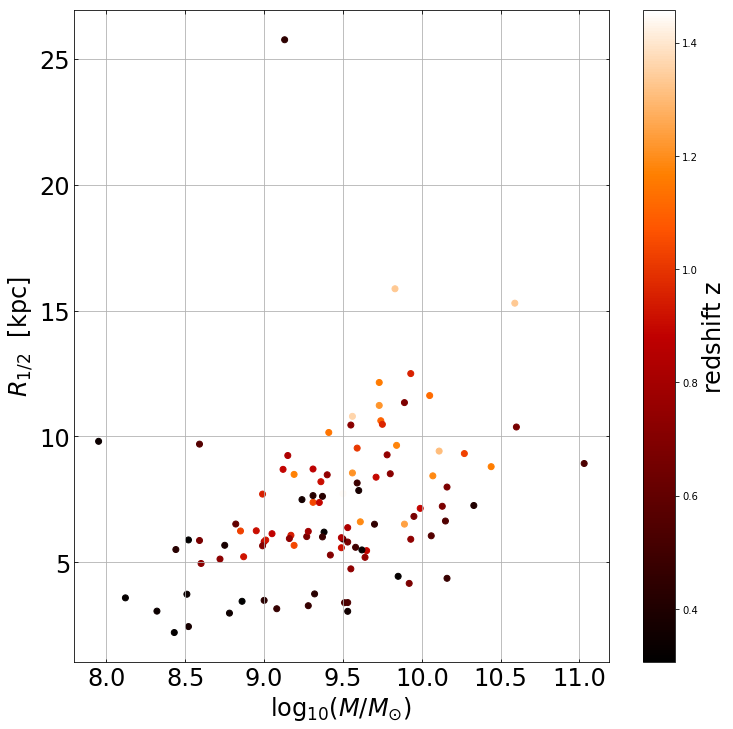

In [35]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

asManyPlots(111, lmassGalsWeWant, sizeGalsWeWant, xlabel=r'$\log_{10} (M/M_{\odot})$', ylabel=r'$R_{1/2} \ \ [\rm{kpc}]$',
            plotFlag=[False], color=[zFromGalsWeWant], marker=['o'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/size_vs_log10Mass.pdf', overwrite=False)

## 1.3 SNR vs size

### 1.3.1 Getting data and Computing SNR

In [36]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### 1.3.2 Plotting SNR vs size (in arcsec)

File Plots/Selection_plots/SNR_vs_R_halfLight_arcsec.pdf already exists but overwritting was disabled. Thus exiting without writing.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe121b58320>,
 [<matplotlib.lines.Line2D at 0x7fe121526fd0>])

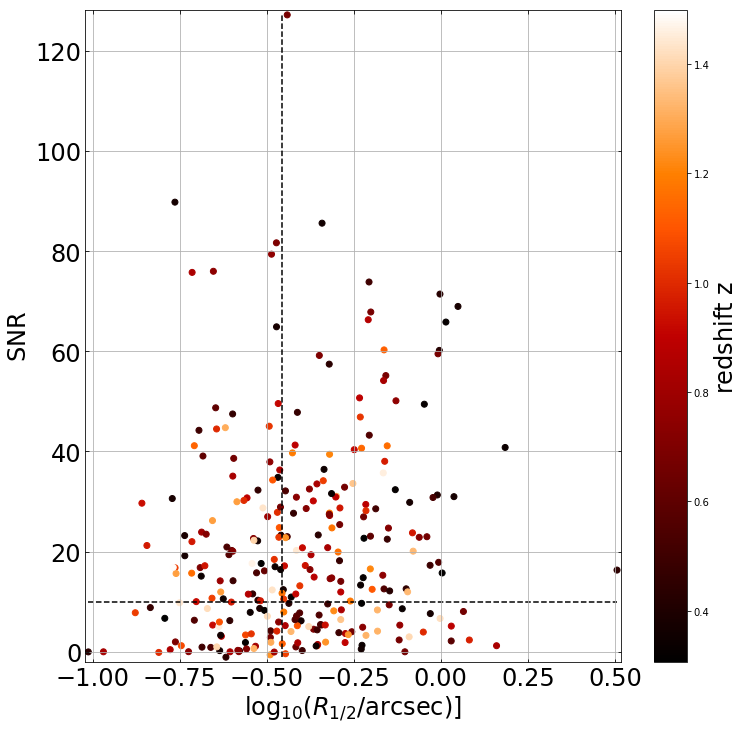

In [37]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

lsize =  np.log10(size)

SNRLineX = [np.min(lsize), np.max(lsize)]
SNRLineY = [10, 10]

lszLineX = [np.log10(0.35), np.log10(0.35)]
lszLineY = [np.min(SNR), np.max(SNR)]

asManyPlots(111, [lsize, SNRLineX, lszLineX], [SNR, SNRLineY, lszLineY], 
            ylabel=r'$\rm{SNR}$', xlabel=r'$\log_{10} (R_{1/2} / \rm{arcsec})]$',
            plotFlag=[False, True, True], color=[redshift, 'k', 'k'], zorder=[0,1,2],
            marker=['o', 'None', 'None'], linestyle=['None', 'dashed', 'dashed'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/SNR_vs_R_halfLight_arcsec.pdf', overwrite=False,
            xlim=[np.min(lsize)-0.01, np.max(lsize)+0.01],
            ylim=[np.min(SNR)-1, np.max(SNR)+1])

### 1.3.3 Plotting SNR vs comoving transverse distance

In [38]:
from cosmolopy.distance import comoving_distance_transverse
cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'omega_k_0' : 0.0, 'h' : 0.72}

redshift = table['Z_MUSE']
#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

#Transforming from arcsec to radians
size /= 3600 #arcsec to degrees
size *= np.pi/180.0 #degrees to radians

#Transforming angular size in comsological transverse size
size *= comoving_distance_transverse(redshift, **cosmo)
size *= 1.0e3 #Mpc to kpc

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


File Plots/Selection_plots/SNR_vs_R_halfLight_kpc.pdf already exists but overwritting was disabled. Thus exiting without writing.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe121ab8400>,
 [<matplotlib.lines.Line2D at 0x7fe12104d978>])

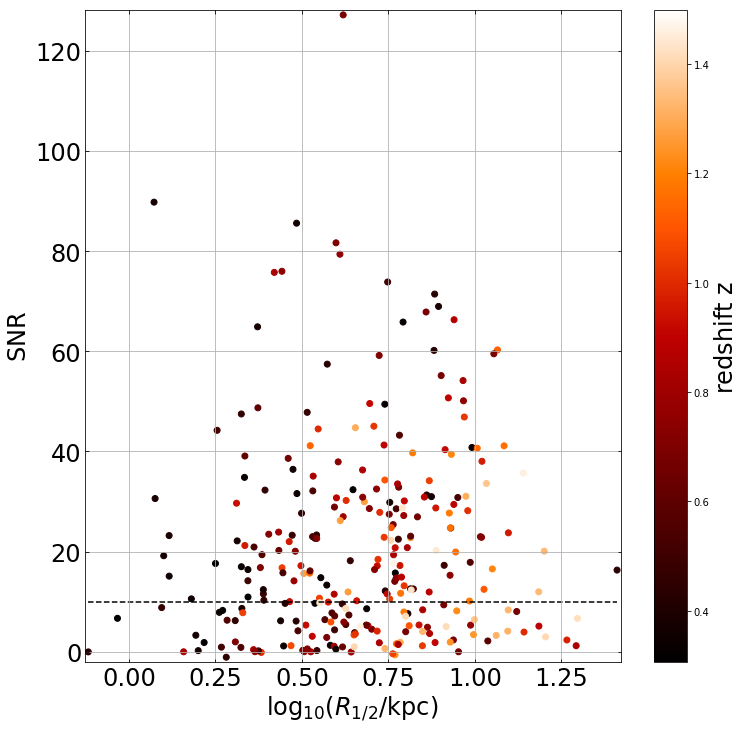

In [39]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

lsize =  np.log10(size)

SNRLineX = [np.min(lsize), np.max(lsize)]
SNRLineY = [10, 10]

asManyPlots(111, [lsize, SNRLineX, lszLineX], [SNR, SNRLineY, lszLineY], 
            ylabel=r'$\rm{SNR}$', xlabel=r'$\log_{10}(R_{1/2} / \rm{kpc})$',
            plotFlag=[False, True, True], color=[redshift, 'k', 'k'], zorder=[0,1,2],
            marker=['o', 'None', 'None'], linestyle=['None', 'dashed', 'dashed'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/SNR_vs_R_halfLight_kpc.pdf', overwrite=False,
            xlim=[np.min(lsize)-0.01, np.max(lsize)+0.01],
            ylim=[np.min(SNR)-1, np.max(SNR)+1])

## 1.4 Redshift histograms

### 1.4.1 Getting data and Computing SNR

In [15]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### 1.4.2 Splitting data into gals we want and gals we do not want

In [16]:
zFromGalsWeWant  = redshift[np.logical_and(SNR>10, size>=0.35)]
zFromGalsNotWant = redshift[np.logical_or(SNR<=10, size<0.35)]

meanZ = np.mean(zFromGalsWeWant)

print("Number of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


### 1.4.3 Plotting histograms

File Plots/Selection_plots/hist_redshift.pdf already exists but overwritting was disabled. Thus exiting without writing.
0.10847545
0.10847548
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545


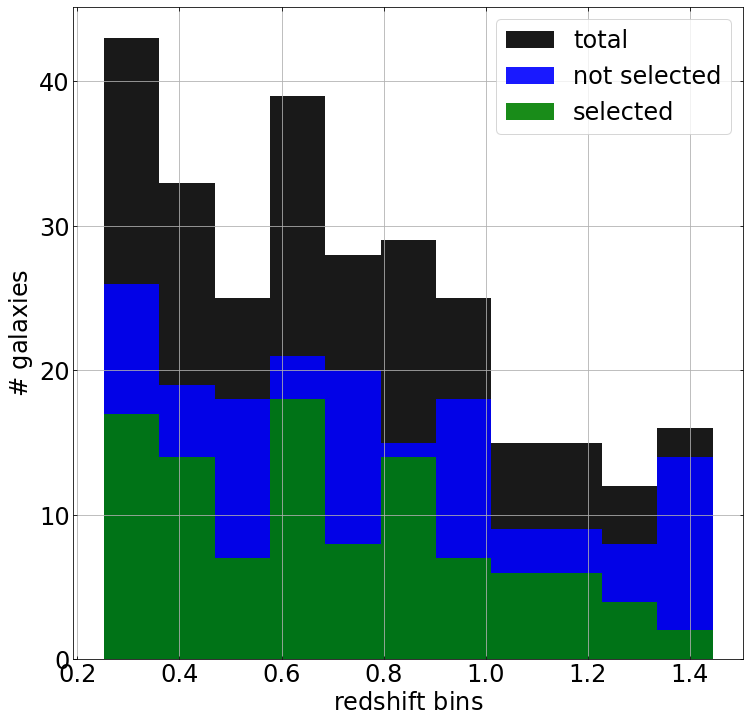

In [42]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)


[zFromGalsNotWant, zFromGalsWeWant]
['black', 'red']
['red', 'black']
label=['not selected', 'selected']

zTot = np.append(zFromGalsNotWant, zFromGalsWeWant)

#Trying to have bins around 0.1 in width
bins = int((np.max(zFromGalsWeWant)-np.min(zFromGalsWeWant))/0.1)
ax, n, bns = asManyHists(111, [zFromGalsWeWant, zFromGalsNotWant, zTot], bins=bins,
                        xlabel=r'$\rm{redshift \,\, bins}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.9,
                        outputName='Plots/Selection_plots/hist_redshift.pdf', overwrite=False)

#Check bins are correct
for i in range(len(bns)-1):
    print(bns[i+1]-bns[i])

### 1.4.3 Plotting cumulative distribution

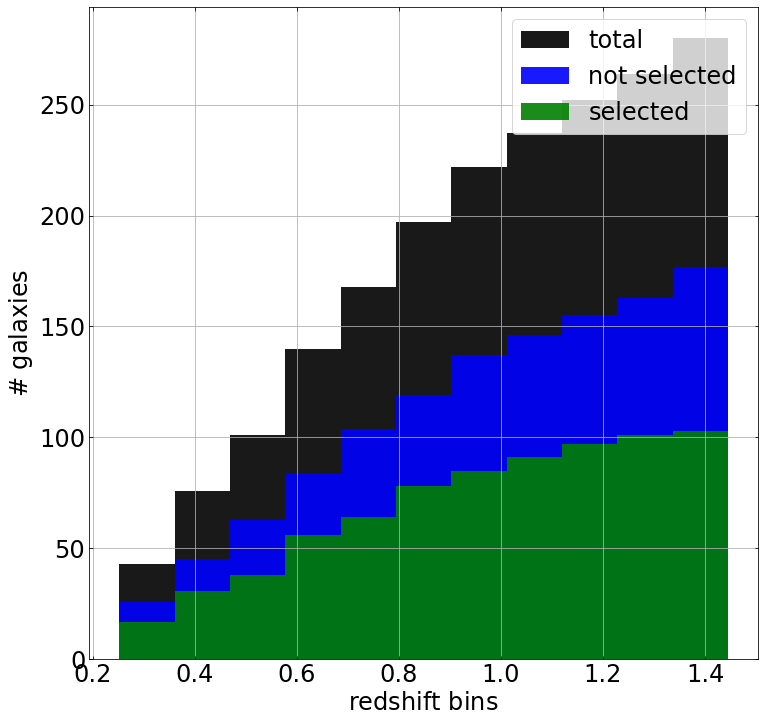

In [7]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)


[zFromGalsNotWant, zFromGalsWeWant]
['black', 'red']
['red', 'black']
label=['not selected', 'selected']

zTot = np.append(zFromGalsNotWant, zFromGalsWeWant)

#Trying to have bins around 0.1 in width
bins = int((np.max(zFromGalsWeWant)-np.min(zFromGalsWeWant))/0.1)
ax, n, bns = asManyHists(111, [zFromGalsWeWant, zFromGalsNotWant, zTot], bins=bins,
                        xlabel=r'$\rm{redshift \,\, bins}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.9,
                        outputName='Plots/Selection_plots/cumulative_hist_redshift.pdf', overwrite=False,
                        cumulative=True)

## 1.5 SFR vs mass

### 1.5.1 Getting data and Computing SNR

In [17]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
lmass                 = table['lmass']
lsfr                  = table['lsfr']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

lsfr, lmass, size, fluxOII, errflux, redshift = applyMask([lsfr, lmass, size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size, lmass, lsfr])

#Compute SNR
SNR     = fluxOII/errflux

#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant = applyMask([redshift, lsfr, lmass], m)

meanZ = np.mean(zFromGalsWeWant)

print("\nNumber of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([lmass, lsfr], astroTableMask=True),
                         maskToRemoveVal([lmass, lsfr]))

lsfr, lmass = applyMask([lsfr, lmass], m)
findWhereIsValue([lmass, lsfr])

print("\nNumber of gals is", np.shape(zFromGalsWeWant)[0])

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4

Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106
No nan was found in array number 0
No nan was found in array number 1

Number of gals is 103


### 1.5.3 Plotting SFR vs mass

File Plots/Selection_plots/SFR_vs_mass.pdf already exists but overwritting was disabled. Thus exiting without writing.


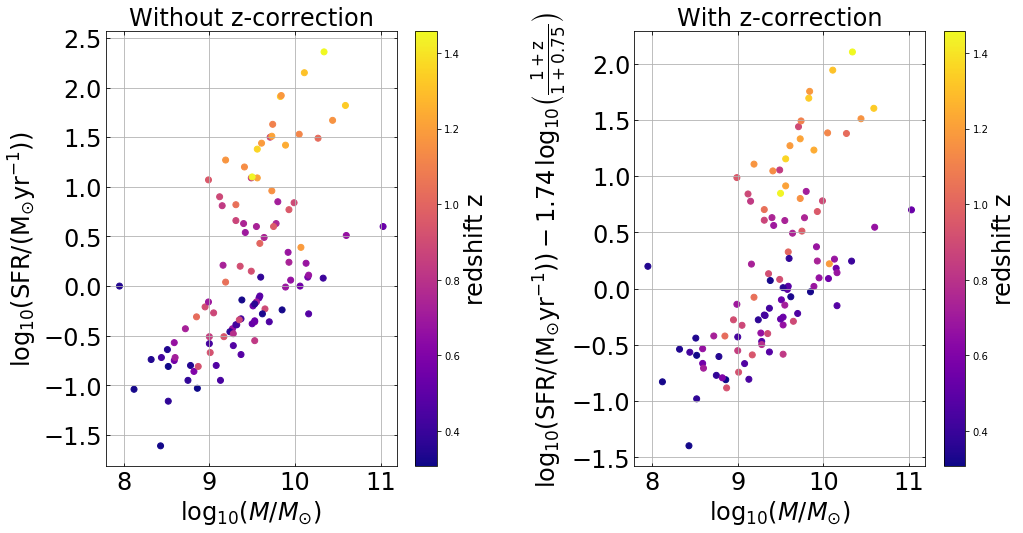

In [19]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

ax1, tmp = asManyPlots(121, lmassGalsWeWant, lsfrGalsWeWant,
                       ylabel=r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1}))$',
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='Without z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

correctedSfr = lsfrGalsWeWant - 1.74*np.log10((1+zFromGalsWeWant)/(1+meanZ))

ylabel   = r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1})) - 1.74 \, \log_{10} \left ( \frac{1+z}{1+%.2f} \right )$' %meanZ
ax1, tmp = asManyPlots(122, lmassGalsWeWant, correctedSfr,
                       ylabel=ylabel,
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='With z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=True)

# 2.BUILDING A TABLE OF FIELD GALS WITH CASSATA AND/OR ZURICH HALF-LIGHT RADIUS COUNTERPART AND ADDING A NEW COLUMN WHICH IS EITHER ZURICH RADIUS OR BIAS CORRECTED CASSATA RADIUS

## Getting data

In [ ]:
pathdata = "outputs/"
data     = ["matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot", 
            "matching_fieldGals_with_Cassata_acc_1_arcsec.vot"]

#Checking that file format is correct
for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

In [ ]:
matchWithCassata       = parse(pathdata+data[1]).get_first_table().array
matchWithZurichCassata = parse(pathdata+data[0]).get_first_table().array

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([matchWithZurichCassata, matchWithCassata], 
                 names=["matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot", 
                        "matching_fieldGals_with_Cassata_acc_1_arcsec.vot"])

In [ ]:
#Converting to an astropy table for simplicity
tableMatchBoth = Table(matchWithZurichCassata)        
tableMatchCass = Table(matchWithCassata)

#Checking that the maximum angular separation is less than 1 arcsec in the matching tables
printSimpleStat([tableMatchBoth['Separation_ZURICH'], tableMatchCass['Separation_CASSATA']])

#Remove galaxies which have wrong ID_Laigle_16 values (9999)
tableMatchBoth = tableMatchBoth[tableMatchBoth['ID_Laigle_16'] != 9999]
tableMatchCass = tableMatchCass[tableMatchCass['ID_Laigle_16'] != 9999]

findWhereIsValue([tableMatchCass['ID_Laigle_16'], tableMatchBoth['ID_Laigle_16']], 9999)

#Remove the galaxy counted twice in the arrays
uniqueArr([tableMatchBoth, tableMatchCass], [tableMatchBoth['ID_Laigle_16'], tableMatchCass['ID_Laigle_16']])

print("\nNumber of galaxies in matching catalog with Cassata:", np.shape(tableMatchCass)[0], 
      "\nNumber of galaxies in matching catalog with Cassata & Zurich:", np.shape(tableMatchBoth)[0])

In [ ]:
#Get a subtable with galaxies having Cassata radius only
mask            = np.in1d(tableMatchCass['ID_Laigle_16'], tableMatchBoth['ID_Laigle_16'], 
                        assume_unique=True, invert=True)
tableCassOnly   = tableMatchCass[mask]

#Keep list of fields which appear in Cassata+Zurich matching catalog but not in Cassata matching catalog
m               = np.in1d(tableMatchBoth.dtype.names, tableCassOnly.dtype.names, assume_unique=True, invert=True)
listFieldsToAdd = np.asarray(tableMatchBoth.dtype.names)[m]

#Adding Zurich columns (default value=-999) to the Table with galaxies in Cassata catalog only
sz = np.shape(tableCassOnly)[0]
for field in listFieldsToAdd:
    tableCassOnly[field] = np.array([-9999]*sz, dtype=tableMatchBoth.dtype[field])

#Correcting biais in Cassata radius
offset         = -3.495e-1
A              = 1.95e-3
R_half_CASSATA = tableCassOnly['R_HALF_CASSATA']/(1+offset+A*tableCassOnly['R_HALF_CASSATA'])

#Creating new column in both tables
newField                 = 'Corrected_radius'
tableMatchBoth[newField] = tableMatchBoth['R50_ZURICH']
tableCassOnly[newField]  = R_half_CASSATA

## Concatenating tables

In [ ]:
newTable = vstack([tableMatchBoth, tableCassOnly], join_type='exact')

## Writing the full table in a new file

In [ ]:
path       = 'outputs/'
outputFile = 'matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot'
# write_array_to_vot(newTable, path+outputFile, isTable=True)